In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import sys
# Add your absolute path of your project folder to system path.
sys.path.append("/content/drive/My Drive/CS 561")
# See the full list of paths in sys.path
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython', '/content/drive/My Drive/CS 561']


In [3]:
%cd "/content/drive/My Drive/CS 561"

/content/drive/My Drive/CS 561


In [4]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import download
from spacy import load
import json
import joblib

from transformers import RobertaTokenizer, RobertaModel
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

download('punkt')
download('stopwords')
download('omw-1.4')
download('wordnet')
nltk.download('wordnet2022')

nlp = load('en_core_web_sm')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package wordnet2022 to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet2022.zip.


In [5]:
df = pd.read_excel('reviews_input.xlsx')
df.columns = ['text', 'label']
df.head()

,text,label
0,Good food and a great view . Extensive menu wi...,5 star rating
1,Excellent service our server thoughtfully spli...,5 star rating
2,If you're looking for a dining experience wher...,5 star rating
3,We had a birthday celebration at the restauran...,4 star rating
4,I recently dined at C Level Restaurant in San ...,5 star rating


In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
df['label'].value_counts()

,count
label,
5 star rating,2533
4 star rating,1002
Poor Rating,665


encode_label = {'5 star rating' : 1, '4 star rating' : 2, 'Poor Rating' : 3 }
df['label'] = df['label'].map(encode_label)
df.head()

In [ ]:
df.shape

(4200, 2)

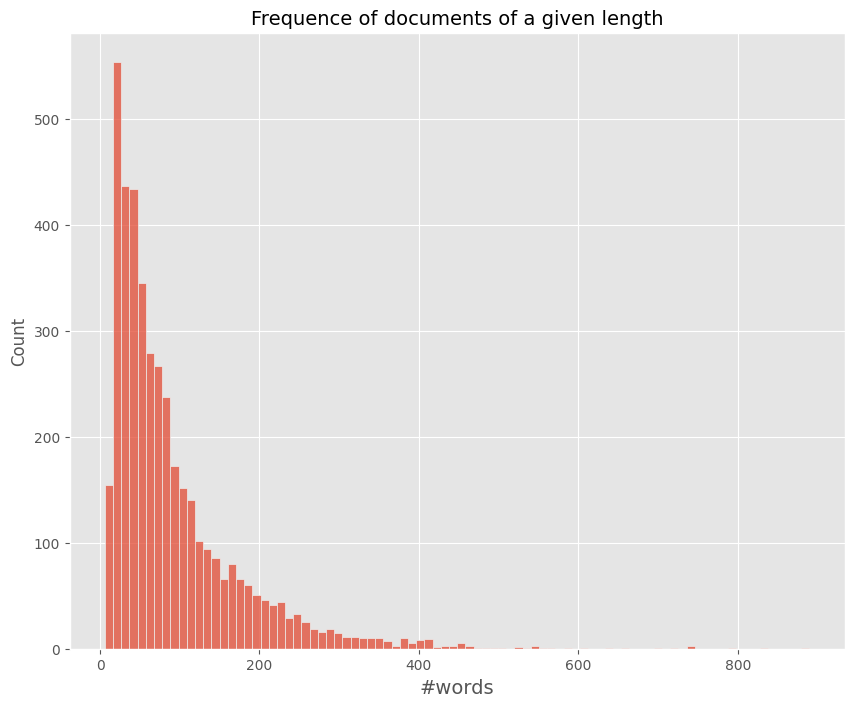

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['#words'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['#words'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('#words', fontsize=14)
None

In [ ]:
print(f"The longest review has {df['#words'].max()} words")
print(f"The shortest review has {df['#words'].min()} words")

The longest review has 890 words
The shortest review has 6 words


In [ ]:
df.drop(['#words'],axis=1,inplace = True)

In [6]:
# Save preprocessed data, cropped to max length of the model
df['text'] = df['text'].apply(lambda x: " ".join(x.split()[:512]))

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[\d\W_]+', ' ', text)
    return text
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [8]:
import nltk
nltk.download('punkt_tab')
df['text'] = df['text'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    stop_words.remove('not')
    return [token for token in tokens if token not in stop_words]
df['text'] = df['text'].apply(remove_stopwords)

In [10]:
lemmatizer = WordNetLemmatizer()
def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]
df['text'] = df['text'].apply(lemmatize_tokens)
df.head()

,text,label
0,"[good, food, great, view, extensive, menu, mos...",5 star rating
1,"[excellent, service, server, thoughtfully, spl...",5 star rating
2,"[looking, dining, experience, ocean, view, mig...",5 star rating
3,"[birthday, celebration, restaurant, friend, ap...",4 star rating
4,"[recently, dined, c, level, restaurant, san, d...",5 star rating


In [11]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

df['text'] = df['text'].apply(lambda x : combine_text(x))
df.head()

,text,label
0,good food great view extensive menu mostly sea...,5 star rating
1,excellent service server thoughtfully split me...,5 star rating
2,looking dining experience ocean view might ste...,5 star rating
3,birthday celebration restaurant friend appetiz...,4 star rating
4,recently dined c level restaurant san diego ou...,5 star rating


In [12]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [13]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 1e-05

In [14]:
from sklearn.metrics import precision_score,recall_score,f1_score
def calculate_metrics(pred, target):
    return {'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro',zero_division=0),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro',zero_division=0),
            }

In [15]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.title = df['text']
        self.labels = df['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.LongTensor([self.labels[index]])
        }

In [16]:
df.reset_index(drop=True, inplace=True)

In [ ]:
'''
from sklearn.model_selection import train_test_split
# Splitting the data: 80% train, 10% validation, 10% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42, stratify=df["label"]
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.2, random_state=42, stratify=temp_labels
)

# Convert to DataFrame (optional)
train_df = pd.DataFrame({"text": train_texts, "label": train_labels})
val_df = pd.DataFrame({"text": val_texts, "label": val_labels})
test_df = pd.DataFrame({"text": test_texts, "label": test_labels})

# Display the splits
print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

'''

Train size: 3360
Validation size: 672
Test size: 168


In [20]:
train_size = 0.85
train_df = df.sample(frac=train_size, random_state=42).reset_index(drop=True)
temp_df = df.drop(train_df.index).reset_index(drop=True)
val_df, test_df = temp_df.iloc[:-50], temp_df.iloc[-50:]

In [21]:
train_df.shape

(3570, 2)

In [22]:
val_df.shape

(580, 2)

In [24]:
test_df.shape

(50, 2)

In [ ]:
'''
train_ratio = int(0.85 * len(df))
valid_ratio = len(df) - train_ratio
train_df, val_df, test_df = df.iloc[:train_ratio], df.iloc[train_ratio:-50], df.iloc[-50:]
'''

In [29]:
train_dataset = CustomDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(val_df, tokenizer, MAX_LEN)

In [30]:
train_loader = torch.utils.data.DataLoader(train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_loader = torch.utils.data.DataLoader(valid_dataset,
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [31]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [32]:
class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.roberta_model = RobertaModel.from_pretrained('roberta-base', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 3)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.roberta_model(
            input_ids,
            attention_mask=attn_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = RoBERTaClass()
model.to(device)
#model = DataParallel(model)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTaClass(
  (roberta_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNor

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [35]:
# Traning for two epochs
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
best_valid_loss = float('inf')  # Initialize with a large value
patience = 5  # Number of epochs to wait for improvement
early_stop_counter = 0  # Counter for early stopping

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask, token_type_ids)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()


    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            targets = batch['targets'].squeeze().to(device)

            outputs = model(input_ids, attn_mask, token_type_ids)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = valid_correct / valid_total
    valid_loss /= len(val_loader)
    result = calculate_metrics(predicted.cpu().numpy(), targets.cpu().numpy())
    val_loss_lst.append(valid_loss)
    val_acc_lst.append(valid_accuracy)
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}')
    print(f'macro f1: {result["macro/f1"]}, micro f1: {result["micro/f1"]}')

    # Early Stopping Logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_counter = 0
        best_epoch = epoch + 1  # Store the epoch with the best validation loss
        torch.save(model.state_dict(), 'best_model_RB.pth')  # Save the best model
        print(f"Best model found at epoch {best_epoch}, saving model.")

    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epoch(s).")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break


Epoch 1/2
Training Loss: 0.8011990737702165, Training Accuracy: 0.6470588235294118, Validation Loss: 0.5475890165881107, Validation Accuracy: 0.7775862068965518
macro f1: 0.42857142857142855, micro f1: 0.75
Best model found at epoch 1, saving model.
Epoch 2/2
Training Loss: 0.5966746878943273, Training Accuracy: 0.7476190476190476, Validation Loss: 0.4541278999102743, Validation Accuracy: 0.8137931034482758
macro f1: 0.42857142857142855, micro f1: 0.75
Best model found at epoch 2, saving model.


In [36]:
# Training for an additional 8 epochs - total 10 epochs of training
EPOCHS = 8

In [37]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask, token_type_ids)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()


    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            targets = batch['targets'].squeeze().to(device)

            outputs = model(input_ids, attn_mask, token_type_ids)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = valid_correct / valid_total
    valid_loss /= len(val_loader)
    result = calculate_metrics(predicted.cpu().numpy(), targets.cpu().numpy())
    val_loss_lst.append(valid_loss)
    val_acc_lst.append(valid_accuracy)
    print(f'Epoch {epoch + 2+ 1}/{EPOCHS+2}')
    print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}')
    print(f'macro f1: {result["macro/f1"]}, micro f1: {result["micro/f1"]}')

    # Early Stopping Logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_counter = 0
        best_epoch = epoch + 2 + 1  # Store the epoch with the best validation loss
        torch.save(model.state_dict(), 'best_model_RB.pth')  # Save the best model
        print(f"Best model found at epoch {best_epoch}, saving model.")

    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epoch(s).")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 3/8
Training Loss: 0.503582587731736, Training Accuracy: 0.7907563025210084, Validation Loss: 0.4158881675255926, Validation Accuracy: 0.843103448275862
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 3, saving model.
Epoch 4/8
Training Loss: 0.4565026930400303, Training Accuracy: 0.8159663865546218, Validation Loss: 0.31263583271127, Validation Accuracy: 0.8741379310344828
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 4, saving model.
Epoch 5/8
Training Loss: 0.3808991803920695, Training Accuracy: 0.8425770308123249, Validation Loss: 0.27799143563759954, Validation Accuracy: 0.9086206896551724
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 5, saving model.
Epoch 6/8
Training Loss: 0.33719514809282763, Training Accuracy: 0.865546218487395, Validation Loss: 0.22629553354100176, Validation Accuracy: 0.9155172413793103
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 6, saving model.
Epoch 7/8
Training Loss: 0.2976722688015018, Training Accuracy: 0.8845

In [38]:
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attn_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        targets = batch['targets'].squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attn_mask, token_type_ids)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()


    train_accuracy = train_correct / train_total
    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    valid_correct = 0
    valid_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attn_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            targets = batch['targets'].squeeze().to(device)

            outputs = model(input_ids, attn_mask, token_type_ids)
            loss = criterion(outputs, targets)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            valid_total += targets.size(0)
            valid_correct += (predicted == targets).sum().item()

    valid_accuracy = valid_correct / valid_total
    valid_loss /= len(val_loader)
    result = calculate_metrics(predicted.cpu().numpy(), targets.cpu().numpy())
    val_loss_lst.append(valid_loss)
    val_acc_lst.append(valid_accuracy)
    print(f'Epoch {epoch + 10 + 1}/{EPOCHS+10}')
    print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_accuracy}')
    print(f'macro f1: {result["macro/f1"]}, micro f1: {result["micro/f1"]}')

    # Early Stopping Logic
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        early_stop_counter = 0
        best_epoch = epoch + 10 + 1  # Store the epoch with the best validation loss
        torch.save(model.state_dict(), 'best_model_RB.pth')  # Save the best model
        print(f"Best model found at epoch {best_epoch}, saving model.")

    else:
        early_stop_counter += 1
        print(f"No improvement for {early_stop_counter} epoch(s).")

    if early_stop_counter >= patience:
        print("Early stopping triggered.")
        break

Epoch 11/15
Training Loss: 0.12402670680811363, Training Accuracy: 0.9549019607843138, Validation Loss: 0.13424769769373693, Validation Accuracy: 0.9655172413793104
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 11, saving model.
Epoch 12/15
Training Loss: 0.1213985867133098, Training Accuracy: 0.9565826330532213, Validation Loss: 0.1298878620574741, Validation Accuracy: 0.9706896551724138
macro f1: 1.0, micro f1: 1.0
Best model found at epoch 12, saving model.
Epoch 13/15
Training Loss: 0.08610259022264342, Training Accuracy: 0.9703081232492997, Validation Loss: 0.14156490924621098, Validation Accuracy: 0.9689655172413794
macro f1: 1.0, micro f1: 1.0
No improvement for 1 epoch(s).
Epoch 14/15
Training Loss: 0.07422160335616874, Training Accuracy: 0.9764705882352941, Validation Loss: 0.15812170451605007, Validation Accuracy: 0.9517241379310345
macro f1: 1.0, micro f1: 1.0
No improvement for 2 epoch(s).
Epoch 15/15
Training Loss: 0.0650826072669588, Training Accuracy: 0.97983193

In [39]:
# Load the best model before inference or evaluation
model.load_state_dict(torch.load('best_model_RB.pth'))

<All keys matched successfully>

In [61]:
len(train_loss_lst)

15

In [62]:
 # save the trained model to disk
 torch.save({
     'epoch': 15,
     'best_epoch': best_epoch,
     'model_state_dict': model.state_dict(),
     'optimizer_state_dict': optimizer.state_dict(),
     'loss': criterion,
     'train_loss': train_loss_lst,
     'valid_loss': val_loss_lst,
     'train_acc': train_acc_lst,
     'valid_acc': val_acc_lst
                 }, 'model_RB.pth')

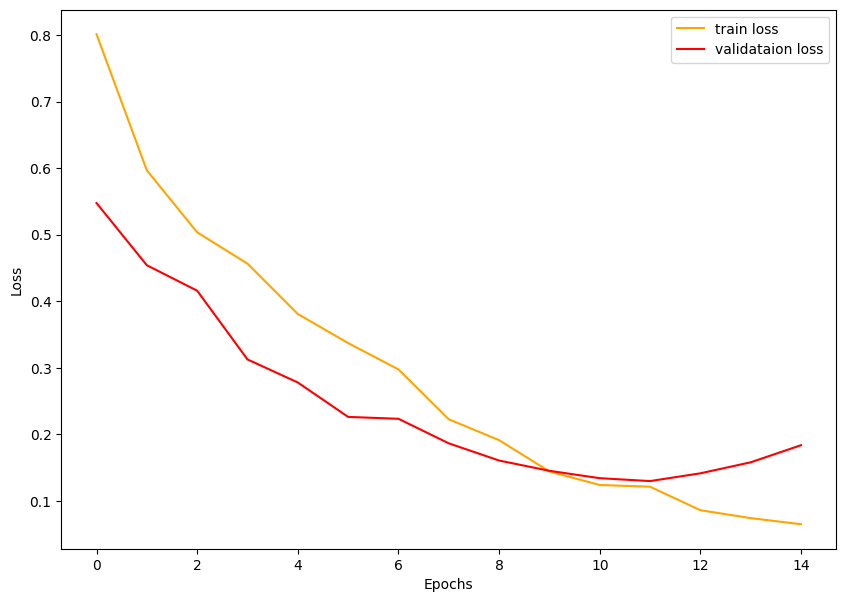

In [40]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss_lst, color='orange', label='train loss')
plt.plot(val_loss_lst, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../loss2.png')
plt.show()

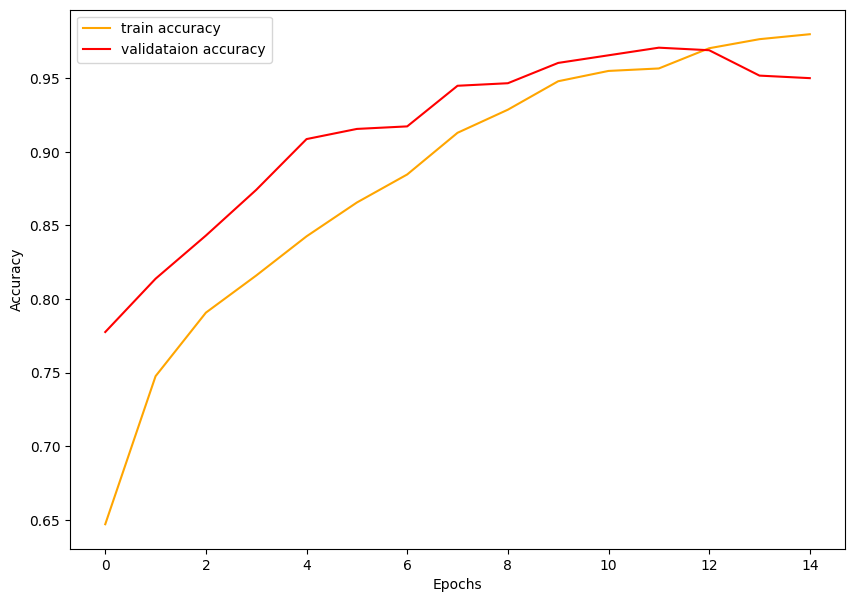

In [41]:
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_acc_lst, color='orange', label='train accuracy')
plt.plot(val_acc_lst, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('../acc2.png')
plt.show()

In [42]:
def predict_text(text, model, tokenizer, max_len, device):
    cleaned_text = clean_text(text)
    tokenized_text = tokenizer.encode_plus(
        cleaned_text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        return_token_type_ids=True,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = tokenized_text['input_ids'].to(device)
    attn_mask = tokenized_text['attention_mask'].to(device)
    token_type_ids = tokenized_text['token_type_ids'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attn_mask, token_type_ids)
        _, predicted_class = torch.max(outputs, 1)

    predicted_label = label_encoder.classes_[predicted_class.item()]

    return predicted_label

In [43]:
test_df.reset_index(drop=True, inplace=True)

In [44]:
test_dataset = CustomDataset(test_df, tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

In [45]:
df_predicted = pd.DataFrame(columns=['text', 'predicted_label', 'actual_label'])
for counter, data in enumerate(test_loader):
    text = data['input_ids'].to(device)
    target = data['targets'].to(device)

    # Get the original text from the test_df DataFrame using the counter as index
    original_text = test_df.loc[counter, 'text']

    predicted_label = predict_text(original_text, model, tokenizer, MAX_LEN, device)
    #print(item)
    df_predicted.loc[counter, 'text'] = original_text
    df_predicted.loc[counter, 'predicted_label'] = predicted_label
    df_predicted.loc[counter, 'actual_label'] = label_encoder.classes_[target.item()] # Extract the label value

In [46]:
df_predicted.head(10)

,text,predicted_label,actual_label
0,c level sea heh came two friend memorial day w...,5 star rating,4 star rating
1,lamb sandwich meat dry bun soggy hard handle s...,Poor Rating,Poor Rating
2,yummy came friend came back take family state ...,5 star rating,5 star rating
3,c level make taste bud happy went celebrate fr...,5 star rating,5 star rating
4,birthday planned week advance arrived told hos...,5 star rating,5 star rating
5,appetizer great calamari brie hit dish ok orde...,Poor Rating,Poor Rating
6,update senate bill set go effect july prohibit...,Poor Rating,Poor Rating
7,surcharge cover increased cost minimum wage ri...,Poor Rating,Poor Rating
8,love place really one city great restaurant ge...,5 star rating,5 star rating
9,even though cooler day june feel one bit sitti...,5 star rating,5 star rating


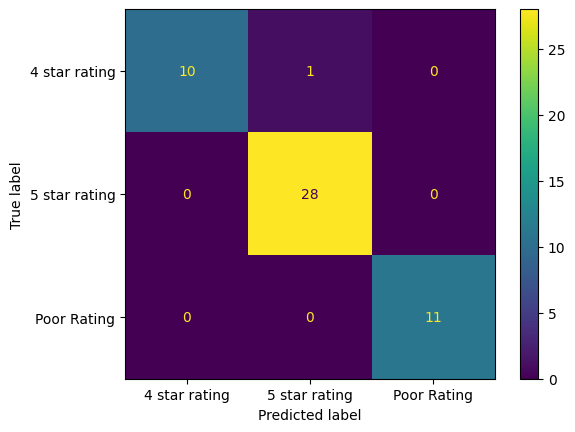

In [47]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(df_predicted['actual_label'], df_predicted['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()
plt.show()

In [48]:
from sklearn.metrics import accuracy_score,classification_report
print(accuracy_score(df_predicted['actual_label'], df_predicted['predicted_label']))
print(classification_report(df_predicted['actual_label'], df_predicted['predicted_label']))

0.98
               precision    recall  f1-score   support

4 star rating       1.00      0.91      0.95        11
5 star rating       0.97      1.00      0.98        28
  Poor Rating       1.00      1.00      1.00        11

     accuracy                           0.98        50
    macro avg       0.99      0.97      0.98        50
 weighted avg       0.98      0.98      0.98        50



In [49]:
df_test = pd.read_excel('reviews_test.xlsx')
df_test.shape

(207, 3)

In [50]:
df_test.head()

,Date,Review,Rating
0,"Oct 24, 2024",Dine in | Dinner | $100+Definitely recomme...,5 star rating
1,"Nov 18, 2024",The service is amazing and the food is so good...,5 star rating
2,"Oct 26, 2024",This is first time for me to try this place. I...,5 star rating
3,"Dec 9, 2024",What is there to say? Amazing Taiwanese food. ...,5 star rating
4,"Dec 6, 2024",As someone who's been to the original Din Tai ...,5 star rating


In [51]:
df_test.drop('Date',axis=1,inplace = True)

In [52]:
df_test.columns = ['text','label']

In [53]:
df_test['label'] = np.where(df_test['label'].isin(['2 star rating','3 star rating','1 star rating']),"Poor Rating" ,df_test['label'])
df_test.head(10)

,text,label
0,Dine in | Dinner | $100+Definitely recomme...,5 star rating
1,The service is amazing and the food is so good...,5 star rating
2,This is first time for me to try this place. I...,5 star rating
3,What is there to say? Amazing Taiwanese food. ...,5 star rating
4,As someone who's been to the original Din Tai ...,5 star rating
5,"I've heard about it, read about and never got ...",5 star rating
6,I love this place! Been here a few times and t...,5 star rating
7,Best restaurant experience I've had in a long ...,5 star rating
8,Food- It will always be a 10/10 eating at din ...,5 star rating
9,I was in the San Diego area meeting up with co...,5 star rating


In [54]:
#label_encoder = LabelEncoder()
df_test['label'] = label_encoder.fit_transform(df_test['label'])

In [55]:
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)
test_loader = torch.utils.data.DataLoader(test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

In [56]:
df_predicted = pd.DataFrame(columns=['text', 'predicted_label', 'actual_label'])
for counter, data in enumerate(test_loader):
    text = data['input_ids'].to(device)
    target = data['targets'].to(device)

    # Get the original text from the test_df DataFrame using the counter as index
    original_text = df_test.loc[counter, 'text']

    predicted_label = predict_text(original_text, model, tokenizer, MAX_LEN, device)
    #print(item)
    df_predicted.loc[counter, 'text'] = original_text
    df_predicted.loc[counter, 'predicted_label'] = predicted_label
    df_predicted.loc[counter, 'actual_label'] = label_encoder.classes_[target.item()]

In [57]:
df_predicted.head(10)

,text,predicted_label,actual_label
0,Dine in | Dinner | $100+Definitely recomme...,5 star rating,5 star rating
1,The service is amazing and the food is so good...,5 star rating,5 star rating
2,This is first time for me to try this place. I...,5 star rating,5 star rating
3,What is there to say? Amazing Taiwanese food. ...,5 star rating,5 star rating
4,As someone who's been to the original Din Tai ...,5 star rating,5 star rating
5,"I've heard about it, read about and never got ...",5 star rating,5 star rating
6,I love this place! Been here a few times and t...,5 star rating,5 star rating
7,Best restaurant experience I've had in a long ...,5 star rating,5 star rating
8,Food- It will always be a 10/10 eating at din ...,5 star rating,5 star rating
9,I was in the San Diego area meeting up with co...,4 star rating,5 star rating


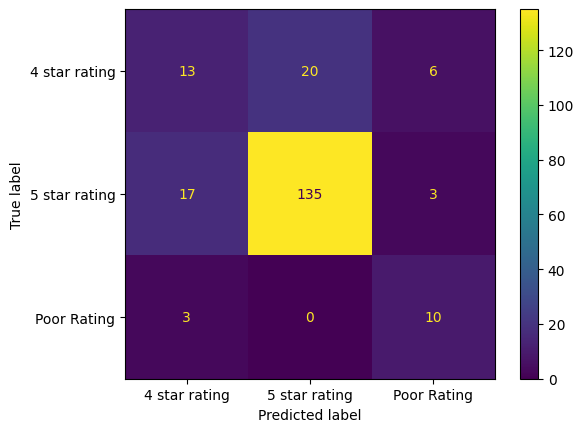

In [58]:
cm = confusion_matrix(df_predicted['actual_label'], df_predicted['predicted_label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=label_encoder.classes_)
disp.plot()
plt.show()

In [59]:
from sklearn.metrics import accuracy_score,classification_report
print(accuracy_score(df_predicted['actual_label'], df_predicted['predicted_label']))
print(classification_report(df_predicted['actual_label'], df_predicted['predicted_label']))

0.7632850241545893
               precision    recall  f1-score   support

4 star rating       0.39      0.33      0.36        39
5 star rating       0.87      0.87      0.87       155
  Poor Rating       0.53      0.77      0.62        13

     accuracy                           0.76       207
    macro avg       0.60      0.66      0.62       207
 weighted avg       0.76      0.76      0.76       207

